In [4]:
#Import bundle sampling and analysis functions
from dreimac import CircularCoords

import circle_bundles as cb
import optical_flow as of


#For saving
import pickle

import pandas as pd

folder_path = '/Users/bradturow/Desktop/Diagrams/Clean_Diagrams/'


# Load The Dataset

In [5]:
#Load the dataset of binary step-edge circles extracted from K_50_60
folder_path = '/Users/bradturow/Desktop/Circle Bundle Code'
file_name = 'K_50_60_Circles.pkl'
file_path = folder_path + file_name

with open(file_path, 'rb') as f:
    [data, C_circ] =pickle.load(f)

#Compute the predominant direction and directionality for each patch
predom_dirs, ratios = of.get_predominant_dirs(data)

#Create a visualizer for optical flow patches
patch_vis = of.make_patch_visualizer()

print(f'Sample contains {len(data)} high-contrast optical flow patches.')
print(f'A total of {len(C_circ)} clusters.')


Sample contains 55501 high-contrast optical flow patches.
A total of 28 clusters.


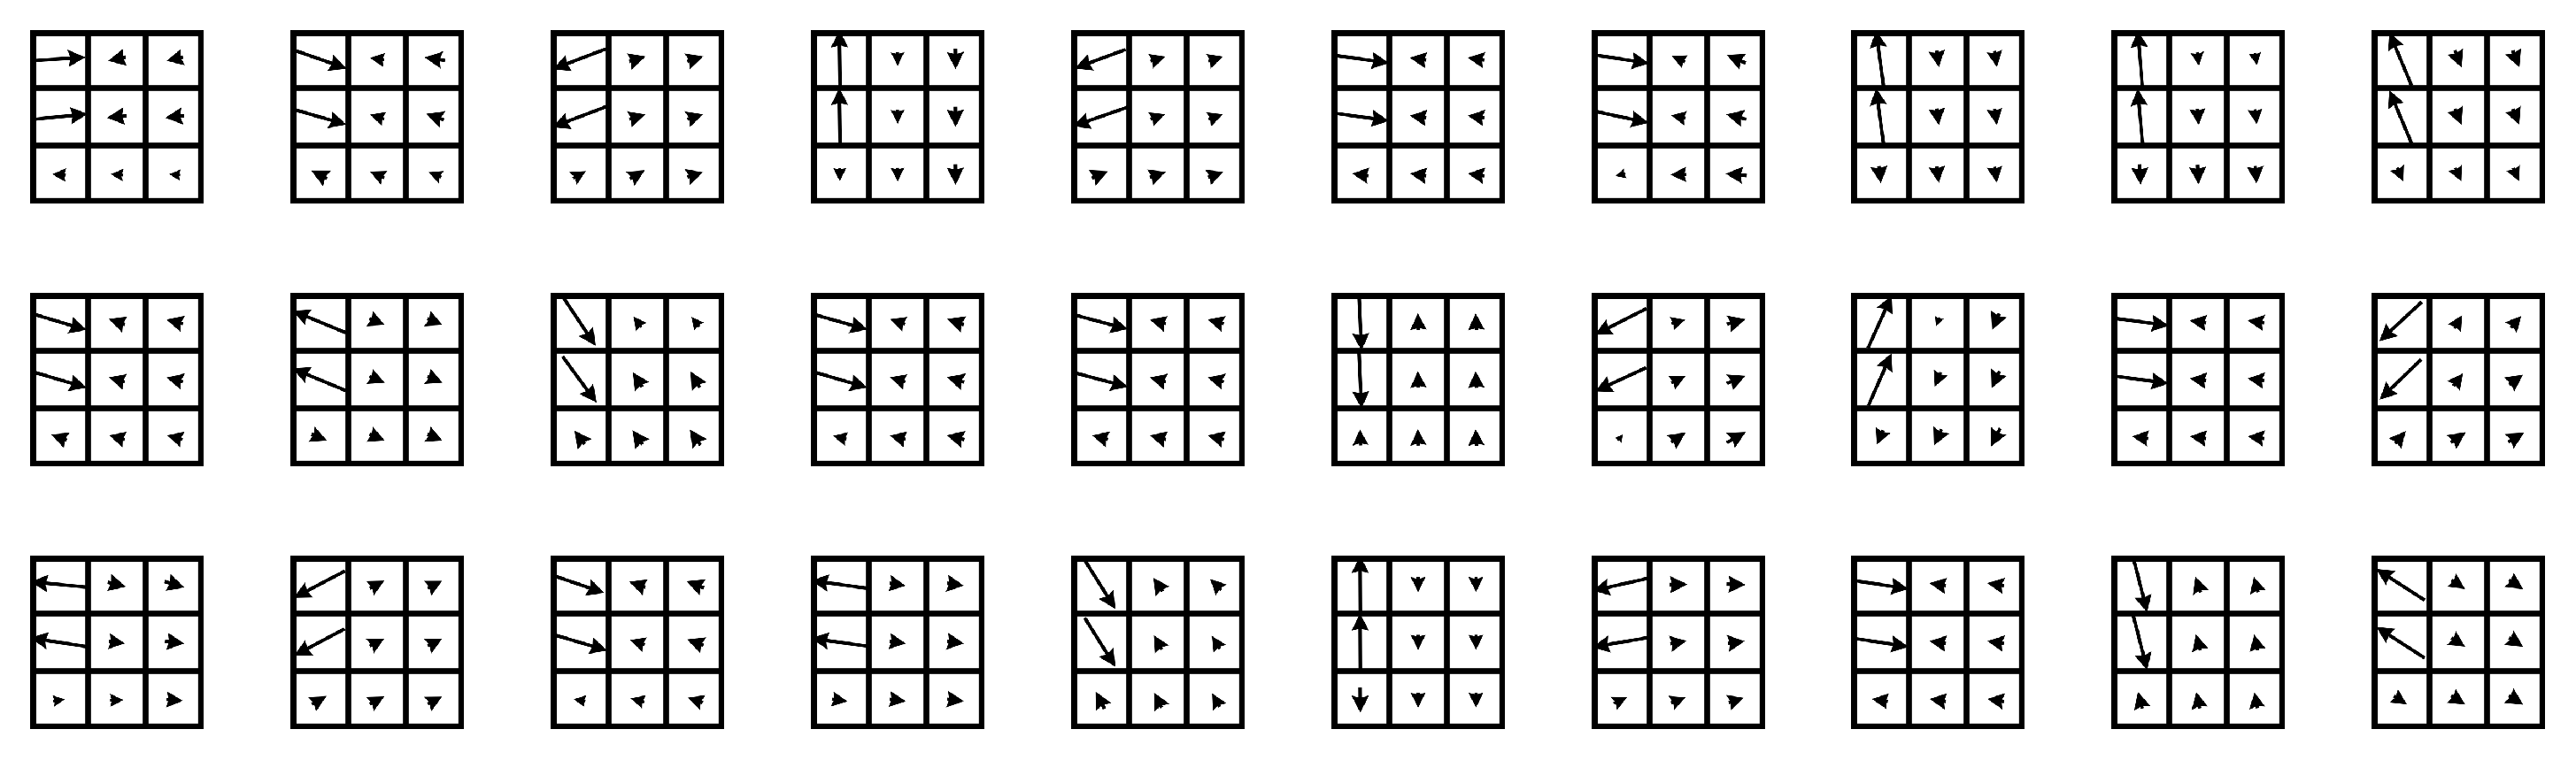

In [6]:
#Show a sample
import matplotlib.pyplot as plt

j = 17 #Choose a circular cluster
fig = cb.show_data_vis(data[C_circ[j]], patch_vis, max_samples = 30)
plt.show()

In [ ]:
#View PCA of the dataset colored according to assigned circular cluster
cb.show_pca(data, U = C_circ, set_cmap = 'turbo', max_points = 20000)


In [ ]:
#Show correlations between circular coordinate and predominant direction on each circular component

#Run circular coordinates on the patches in each cluster 
to_show = [9, 11, 15]
n_landmarks = 100
prime = 17

circle_datasets = []
all_angles = []
titles = []

for j in to_show:
    indices = C_circ[j]
    circle_datasets.append(data[indices])
    cc = CircularCoords(data[indices], n_landmarks, prime=prime)
    all_angles.append(cc.get_coordinates())
    titles.append(f'Component {j}')

file_name = 'Sample_ccs_50_60.pdf'
save_path = folder_path + file_name

fig, axes = cb.circle_vis_grid(
    circle_datasets,
    all_angles,
    patch_vis,
    titles=titles,
    per_circle=8,
    circle_radius=1.0,
    extent_factor=1.2,
    circle_zoom=0.13,
    circle_linewidth=1.0,
    circle_color="black",
    n_cols=3,
    title_fontsize=16,
    figsize_per_panel=5,
    fig_dpi=150,
    save_path=None,
)
plt.show()

#Show correlations between circular coordinate and predominant direction on each circular component
angle_arrays = []
to_compare = []
labels = []
empty_titles = []
for j, ang_arr in enumerate(all_angles):
    angle_arrays.append(ang_arr)
    indices = C_circ[to_show[j]]
    predoms = predom_dirs[indices]
    angle_arrays.append(predoms)
    if j == 0:
        labels.append(f'Circular Coordinate')
    else:
        labels.append('')
    labels.append(f'Predominant Flow Axis')
    empty_titles.append('')
    to_compare.append([2*j+1,2*j])



fig = cb.compare_angle_pairs(
    angle_arrays,
    to_compare,
    x_range = (0,np.pi),
    labels = labels,
    align = False,
    s = 1.0,
    fontsize = 14,
    ncols = 3,
    titles = empty_titles,
    titlesize = 20,
    show_metrics = False)
plt.show()




## Lifting The Step Edge Circles

### Cover And Nerve Summary
- $n_\text{sets} = 16$, $n_\text{samples} = 55501$

**Recorded Simplex Counts:**

- $\#(\text{0-simplices}) = 16$
- $\#(\text{1-simplices}) = 16$
- *No recorded simplices in dimensions* $\ge 2$

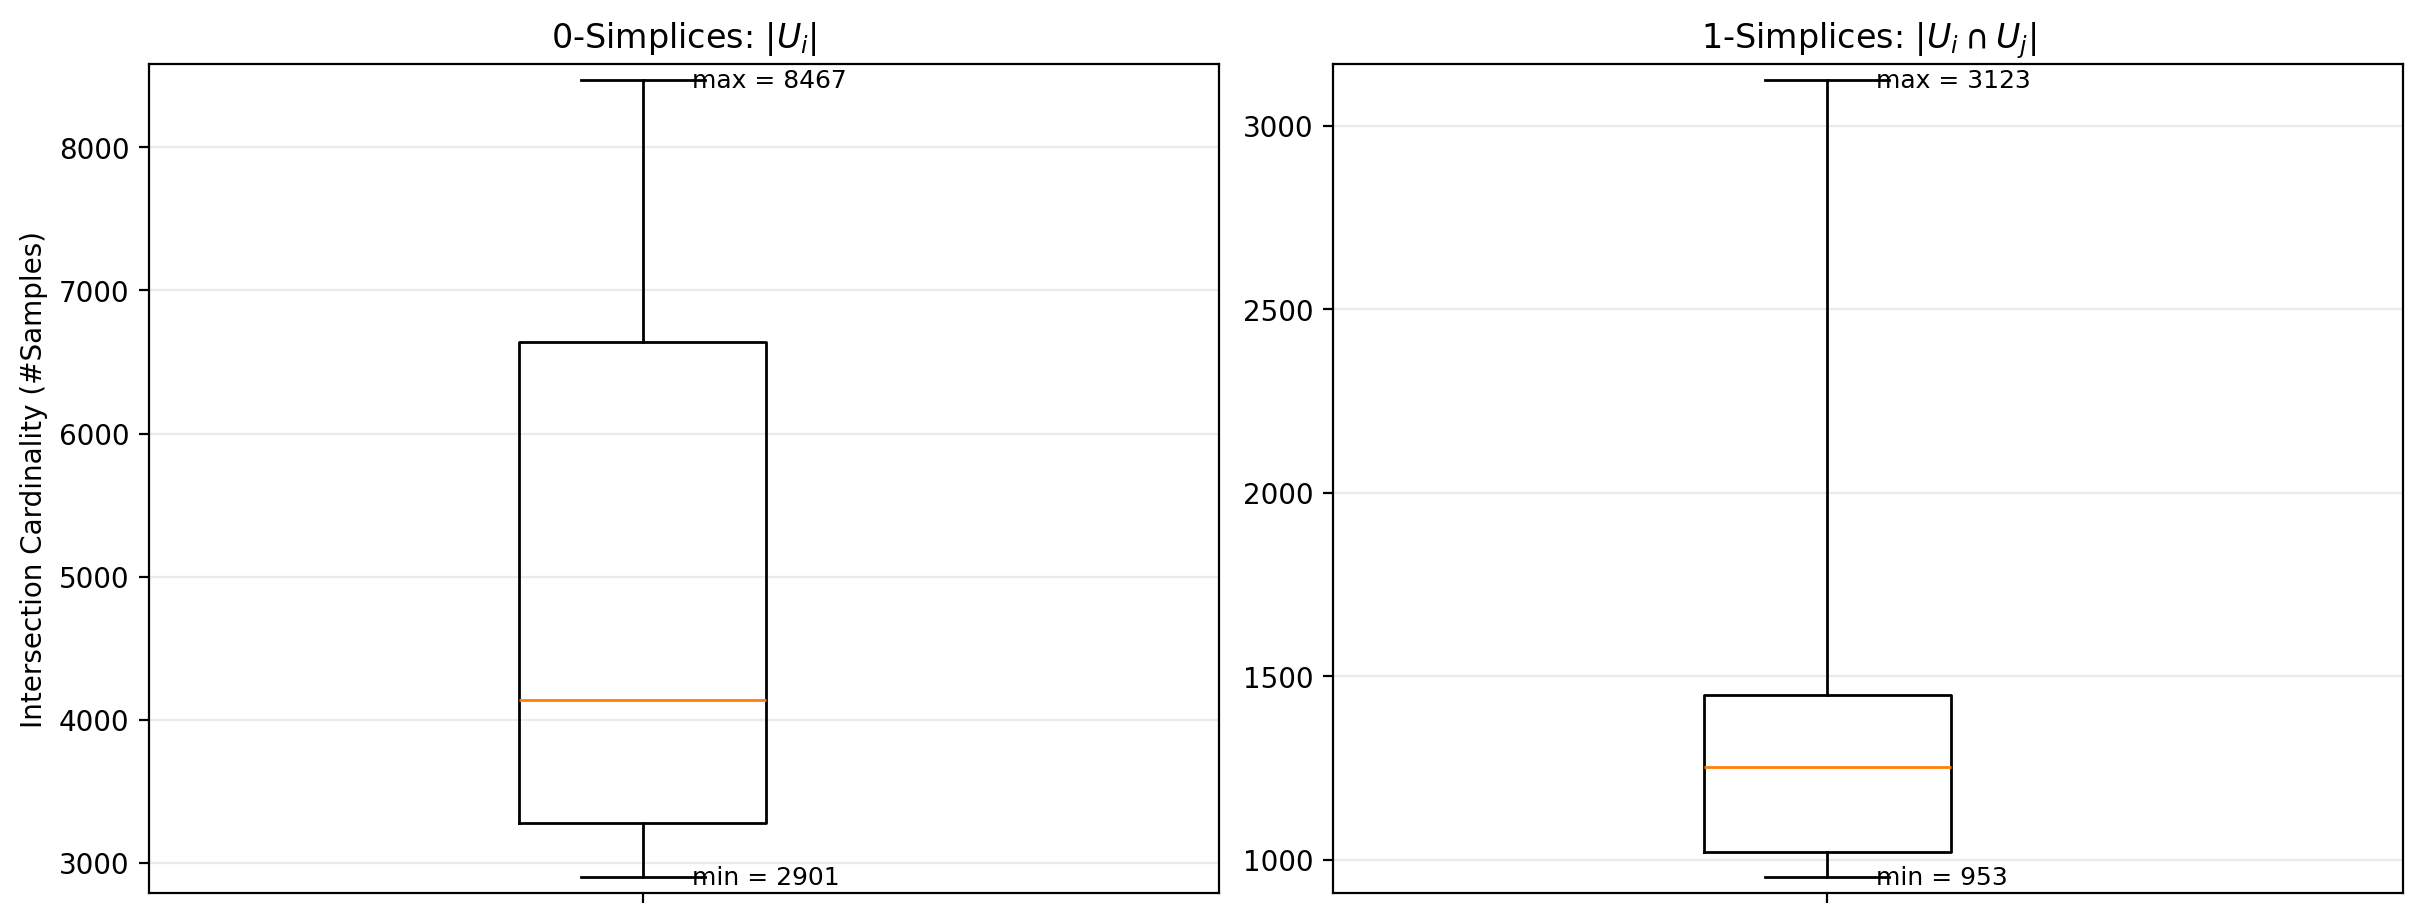

In [7]:
#Compute lifted predominant angles in S1
lifted_base_points = of.get_lifted_predom_dirs(data, eps=1e-12)

n_landmarks = 16
lmk_angs = np.linspace(0, 2*np.pi,n_landmarks, endpoint= False)
landmarks = np.array([np.cos(lmk_angs), np.sin(lmk_angs)]).T
overlap = 1.5
radius = overlap* np.pi/n_landmarks

from circle_bundles import S1UnitVectorMetric as s1_metric

lifted_cover = cb.MetricBallCover(lifted_base_points, landmarks, radius, metric = s1_metric())

lifted_cover_data = lifted_cover.build()

lifted_summ = lifted_cover.summarize(plot = True)

Retries: 0, Number of landmarks used: 200

Cumulative Explained Variance:
  k=1: 0.3512
  k=2: 0.6627
  k=3: 0.7608


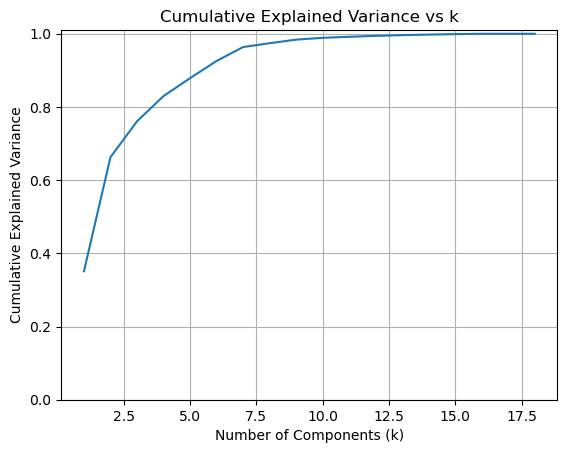

In [10]:
#Try running circular coordinates on a single open set
j= 6
n_local_landmarks = 200
prime = 43
fiber_data = data[lifted_cover.U[j]]
patch_angles, n_warnings, n_lmks = cb.compute_circular_coords_dreimac(fiber_data, 
                                                                   n_landmarks_init = n_local_landmarks, 
                                                                   CircularCoords_cls = CircularCoords)

print(f'Retries: {n_warnings}, Number of landmarks used: {n_lmks}')
print('')
cb.show_pca(fiber_data, colors = patch_angles)




In [13]:
#Compute local trivializations and characteristic classes
lifted_bundle = cb.build_bundle(
    data,
    lifted_cover,
    CircularCoords_cls=CircularCoords,
    show=True)


<IPython.core.display.Math object>

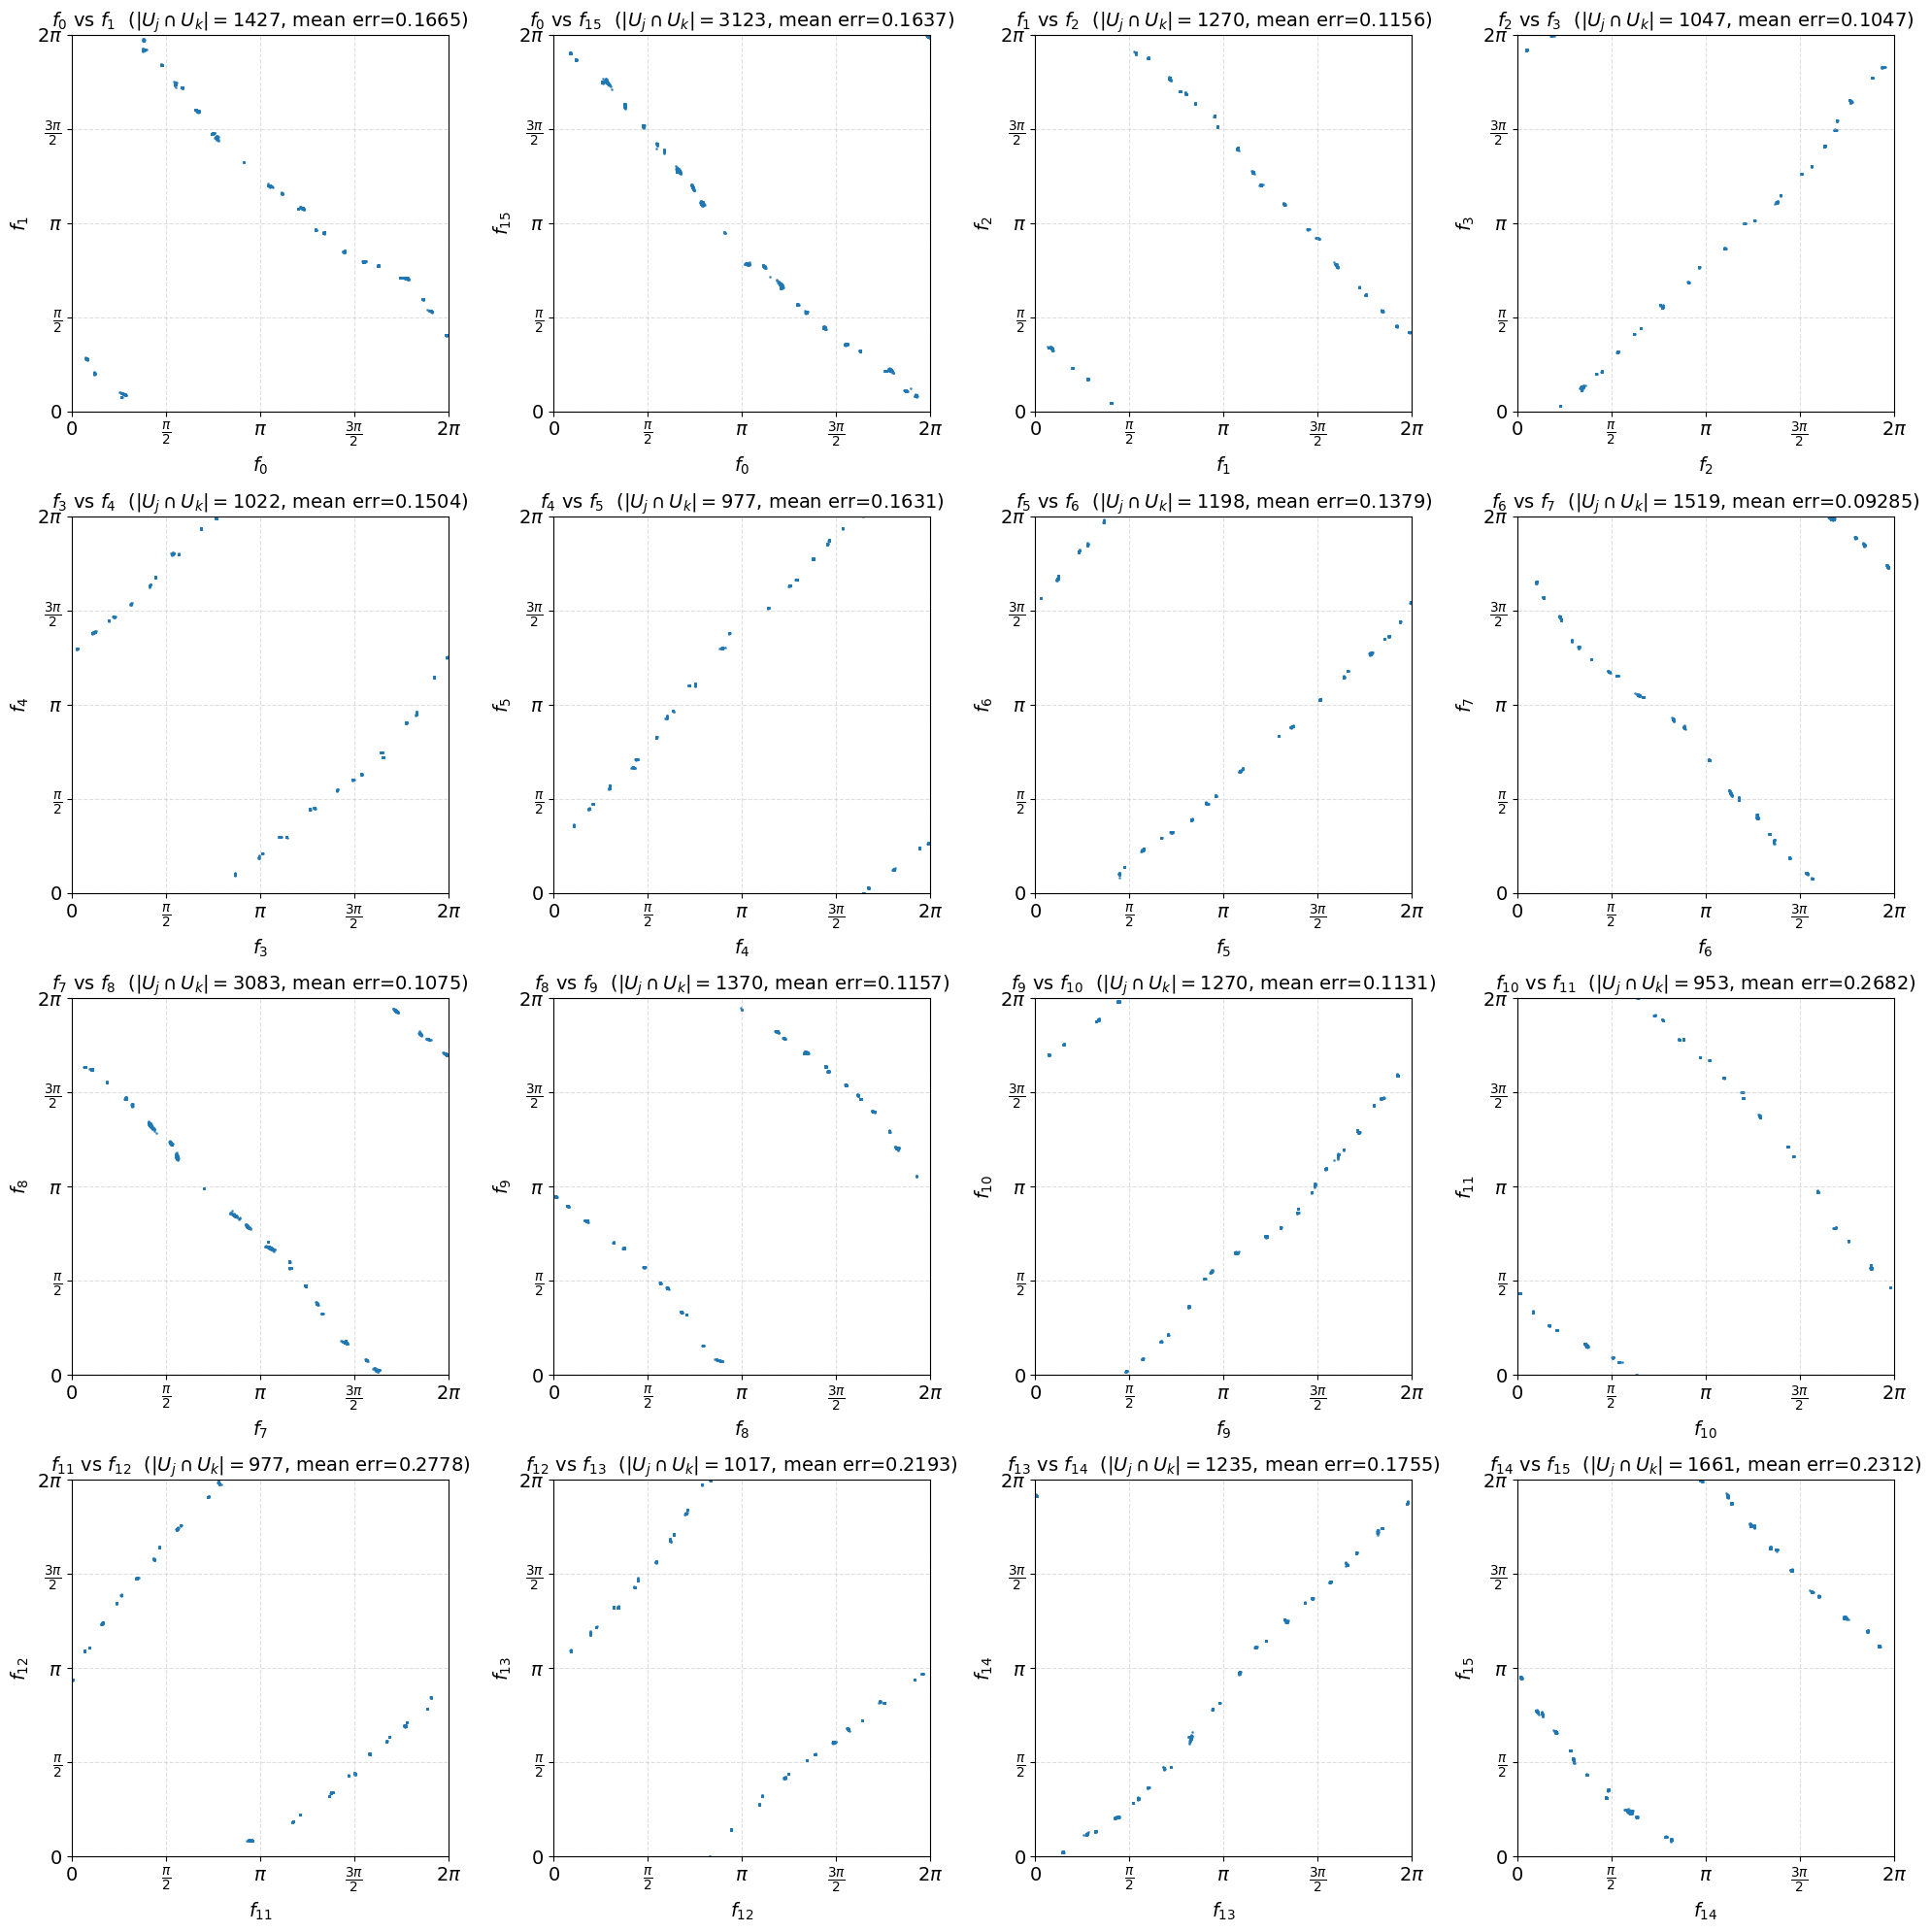

In [15]:
cb.attach_bundle_viz_methods()

fig = lifted_bundle.compare_trivs()
plt.show()

In [16]:
triv_result = lifted_bundle.get_global_trivialization()
fiber_angles = triv_result.F
print('Global coordinates computed.')

Global coordinates computed.


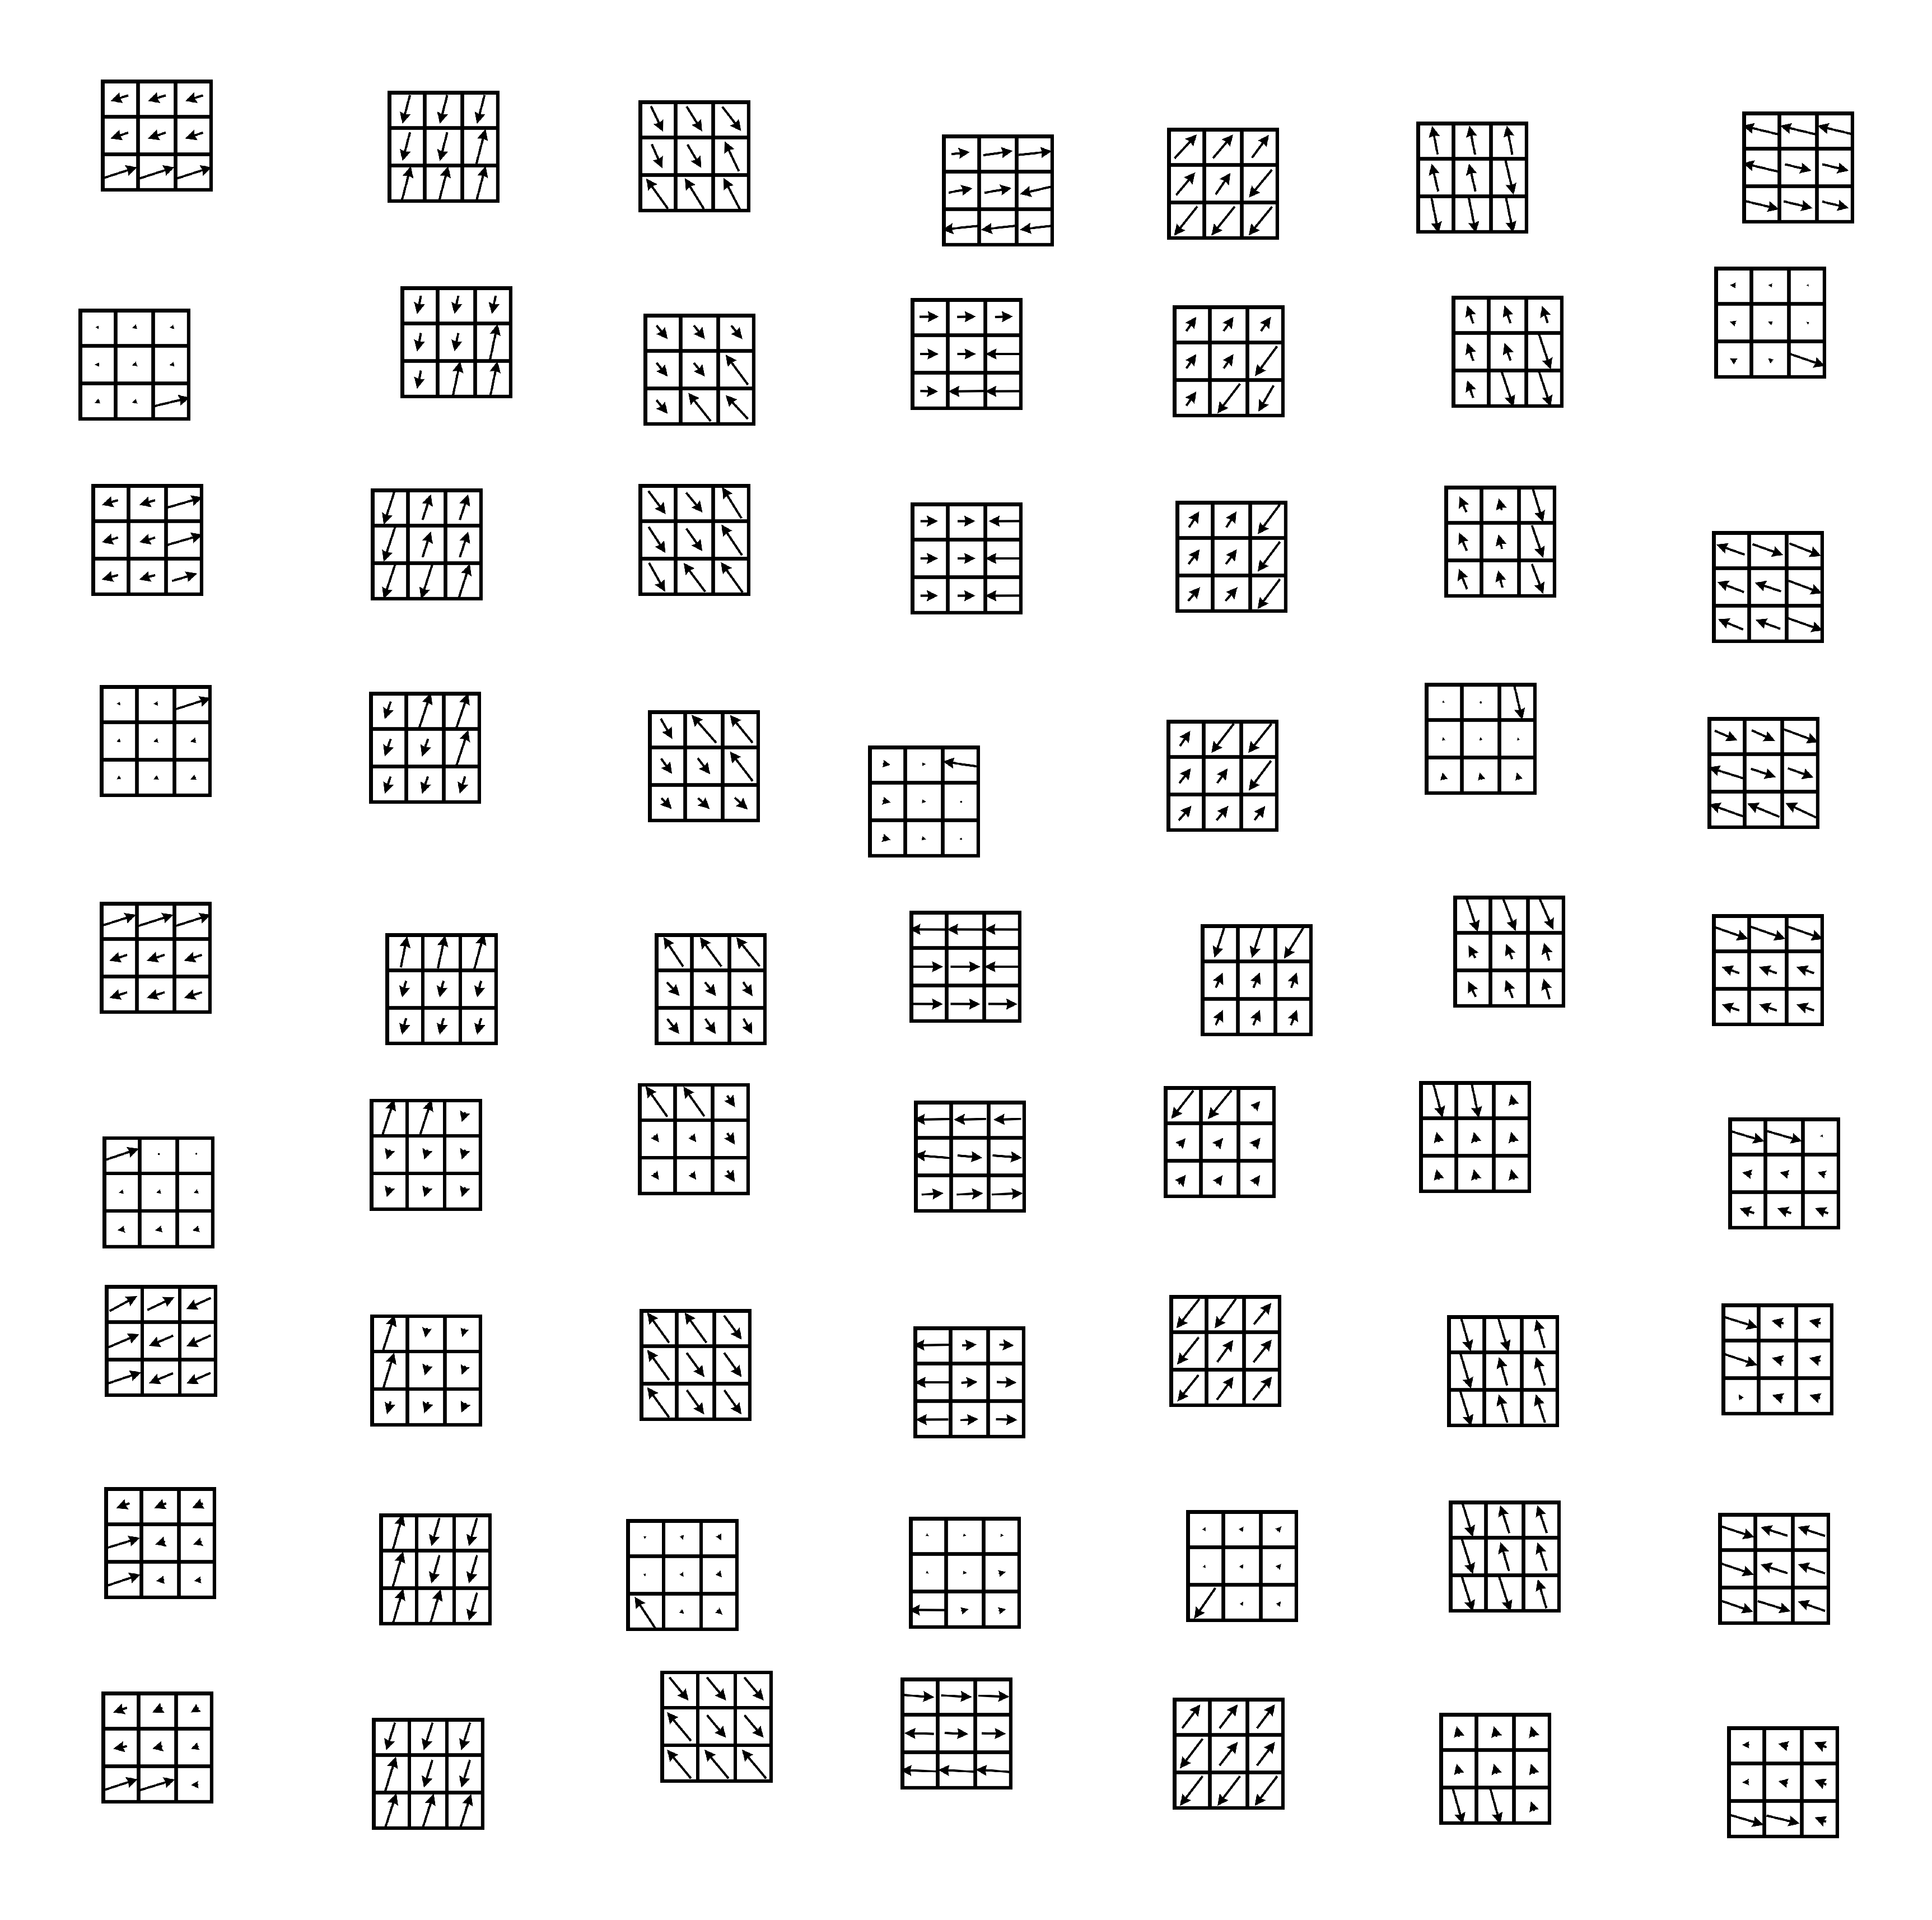

In [19]:
#Show a sample of coordinatized data

base_angles = np.arctan2(lifted_cover.base_points[:,1], lifted_cover.base_points[:,0]) % (2*np.pi)
coords = np.array([base_angles, fiber_angles]).T
file_name = 'Recovered_Lifted_Step_Edge_Torus.pdf'
save_path = folder_path + file_name
save_path = None
fig = cb.lattice_vis(data, coords, patch_vis, 
                             per_row=7,
                              per_col = 9,
                             figsize=22, save_path = save_path)
plt.show()


In [20]:
#Show an interactive visualization of the bundle structure
app = lifted_bundle.show_bundle(colors = fiber_angles)
plt.show()

Bundle viewer running at: http://127.0.0.1:59570/


In [21]:
#Show an interactive visualization of the original bundle structure

from circle_bundles.viz.bundle_dash import *
base_points = np.array([np.cos(2*predom_dirs), np.sin(2*predom_dirs)]).T

app = show_bundle_vis(
    base_points = base_points,
    data = data,
    base_metric = None,
    initial_r = 0.1,
    r_max = 2.0,
    colors = fiber_angles,
    landmark_inds = None,
    max_samples = 10_000)
plt.show()

Bundle viewer running at: http://127.0.0.1:59660/
